## Set 1

### Challenge 1

Convert hexadecimal to base64 encoding

In [3]:
import base64


def hex2base64(s):
    return base64.b64encode(bytes.fromhex(s)).decode('utf-8')


input = '49276d206b696c6c696e6720796f757220627261696e206c696b65206120706f69736f6e6f7573206d757368726f6f6d'
wanted = 'SSdtIGtpbGxpbmcgeW91ciBicmFpbiBsaWtlIGEgcG9pc29ub3VzIG11c2hyb29t'

assert hex2base64(input) == wanted

### Challenge 2

Fixed XOR encryption. Given plaintext and key of the same length, XOR the plaintext with the key to get the ciphertext. XOR with the key once again to recover the plaintext

In [6]:
def fixed_xor(plain, key):
    assert len(plain) == len(key)
    
    output = bytearray(len(plain))
    for i in range(len(plain)):
        output[i] = plain[i] ^ key[i]
    
    return output

In [7]:
input = '1c0111001f010100061a024b53535009181c'
key = '686974207468652062756c6c277320657965'
wanted = '746865206b696420646f6e277420706c6179'


assert fixed_xor(bytes.fromhex(input), bytes.fromhex(key)).hex() == wanted

### Challenge 3

Decrypt single byte XOR encryption. Given plaintext and a single byte key, XOR each byte in the plaintext with the key to get the ciphertext. The challenge is to decrypt this ciphertext

In [8]:
def onebyte_xor(input, key):
    output = bytearray(len(input))
    for i in range(len(input)):
        output[i] = key ^ input[i]
    return output

To start we make two utility functions:
- `distribution` reads an array of bytes and computes the distribution (probability) of each byte
- `score` is a metric of similarity between two byte distributions

We then approximate the distribution of english ascii text by reading the byte distribution from Moby Dick.

In [10]:
def distribution(buf):
    "Measure the distribution of bytes in a buffer"
    dist = [0 for x in range(256)]
    for b in buf:
        dist[int(b)] += 1
    
    return [x / len(buf) for x in dist]


def score(dist1, dist2):
    return sum(x * y for (x,y) in zip(dist1, dist2))


with open("data/moby-dick.txt", "rb+") as f:
    moby_dick = f.read()

english = distribution(moby_dick)

Next, we create a function to find the best single-byte xor key from single-byte xor ciphertext. This just bruteforces the problem by trying each of the 256 keys and measures how similar they are to the Moby Dick distribution

In [13]:
def bestkey(buf):
    scores = 256 * [0]
    for i in range(256):
        dist = distribution(onebyte_xor(buf, i))
        scores[i] = score(dist, english)

    winning_score = max(scores)
    return scores.index(winning_score)

Finally, we decrypt the given ciphertext

In [14]:
input = bytes.fromhex("1b37373331363f78151b7f2b783431333d78397828372d363c78373e783a393b3736")

key = bestkey(input)
onebyte_xor(input, key).decode('utf-8')

"Cooking MC's like a pound of bacon"

### Challenge 4

Detect one-byte xor ciphertext. One approach would be to try decrypting as above and look at how "good" the best key returned is. This is essentially what the challenge hints for you to do. Instead, I've taken a different approach: one-byte XOR is equivalent to a unitary change of basis in our byte distributions. The entropy is invariant under unitart change of basis. Lets just compute the entropy of all these texts and look for a low-entropy candidate

In [16]:
f = open("data/challenge4.txt")
input = list(map(lambda x: bytes.fromhex(str.strip(x)), f))
f.close()

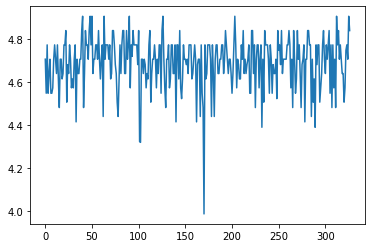

In [17]:
import math
from matplotlib import pyplot


def entropy(buf):
    dist = distribution(buf)
    return -sum(0 if p == 0 else p * math.log2(p) for p in dist)


# Plot entropy for each potential ciphertext and look for a
# low entropy candidate
pyplot.plot(list(map(entropy, input)))

Yup, there is a clear candidate that is lower entropy than the others (which are presumably white noise or something high entropy). Lets find that low entropy candidate

In [19]:
entropies = list(map(entropy, input))
candidate = input[entropies.index(min(entropies))]
candidate

b'{ZB\x15A]TA\x15A]P\x15ETGAL\x15\\F\x15_@XE\\[R?'

And decrypt

In [21]:
# Decrypt candidate
winner = bestkey(candidate)

onebyte_xor(candidate, winner).decode("utf-8")

'Now that the party is jumping\n'

### Challenge 5

Repeated key xor. This cipher is between the one-byte xor and fixed-xor:
- Choose a key of length `N`
- XOR the first `N` bytes of plaintext with the key to create the first `N` bytes of ciphertext
- Shift the key along the plaintext to the next `N` bytes and repeat

In [22]:
def repeating_key_xor(input, key):
    output = bytearray(len(input))
    for i, val in enumerate(input):
        output[i] = key[i % len(key)] ^ input[i]
    return output

In [24]:
input = b"""Burning 'em, if you ain't quick and nimble
I go crazy when I hear a cymbal"""
key = b'ICE'
wanted = '0b3637272a2b2e63622c2e69692a23693a2a3c6324202d623d63343c2a26226324272765272a282b2f20430a652e2c652a3124333a653e2b2027630c692b20283165286326302e27282f'

assert repeating_key_xor(input, key).hex() == wanted

### Challenge 6

Decrypt repeating key xor. The challenge here points out that Hamming distance will be important here. Lets implement Hamming distance between two bytes:

In [34]:
def hamming(x, y):
    # Counting the ones in x ^ y results in the number of differing
    # bits. This is the Hamming distance
    diff = x ^ y
    count = 0
    while diff != 0x00:
        count += diff & 0x01
        diff = diff >> 0x01
    return count


assert hamming(0xff, 0x00) == 8
assert hamming(0xff, 0xff) == 0
assert hamming(0x00, 0x00) == 0
assert hamming(0xaf, 0xaf) == 0

Lets know think about the Hamming distance of ASCII characters relative to one another and how they change under XOR with a byte.

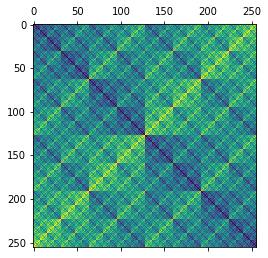

In [39]:
import numpy as np

ascii_hamming = np.zeros((256,256))
for i in range(256):
    for j in range(256):
        ascii_hamming[i, j] = hamming(i, j)


pyplot.matshow(ascii_hamming)

The ASCII letters are roughly 60 - 120. Looks like the Hamming distance between these bytes is quite small. Lets see how the Hamming distance changes under single byte XOR. We'll use `0xa4` for example.

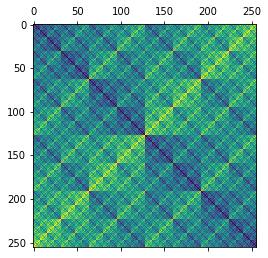

In [41]:
key = 0xa4

ascii_encrypted_hamming = np.zeros((256,256))
for i in range(256):
    for j in range(256):
        ascii_encrypted_hamming[i, j] = hamming(i ^ key, j ^ key)


pyplot.matshow(ascii_encrypted_hamming)

Surprise surprise, the Hamming distance is invariant under XOR. Or perhaps not so surprising as the XOR flips the same bits in each both bytes. What this means for repeated key XOR encryption is that the bytes one key length away from one another will be close together in Hamming space and we can use this to detect the key length.

Lets create a function that computes the average hamming distance between two blocks: `block_hamming`

In [43]:
def block_hamming(x, y):
    assert len(x) == len(y)
    return sum(hamming(x[i], y[i]) for i in range(len(x))) / len(x)



assert block_hamming(bytes.fromhex('ffff'), bytes.fromhex('0000')) == 8
assert block_hamming(bytes.fromhex('ff'), bytes.fromhex('00')) == 8

Alright, now lets load up the data and see if we can figure out the key length with this block hamming function

In [48]:
with open("data/challenge6.txt") as f:
    input = base64.b64decode("".join(map(str.strip, f)))

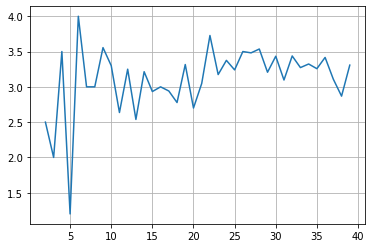

In [85]:
lengths = list(range(2, 40))
scores = list(0 for i in lengths)

for index, length in enumerate(lengths):
        scores[index] = block_hamming(input[:length], input[length:(2*length)])

pyplot.plot(lengths, scores)
pyplot.grid()

Sweet. Key size of 5 looks like a good starting point. Lets regroup all data into these windows and crack the key one character at a time:

In [113]:
window = 5

ciphers = window * [bytearray()]
for i in range(window):
    for j in range(i, len(input), window):
       ciphers[i].append(input[j])


list(map(bestkey, ciphers))

[110, 110, 110, 110, 110]

Huh.... that didn't really work did it. I see why people end up complaining about this question.


Lets try a different approach. Entropy to the rescue again. Lets loop over window sizes. For each window size we'll group together the first byte of each window and compute the entropy of that collection of bytes. When we hit the right window size the entropy should be low. The wrong window sizes should have higher relative entropy!

In [119]:
windows = list(range(2, 45))
entropies = []

for window in windows:
    buf = bytearray()
    for i in range(0, len(input), window):
        buf.append(input[i])
    entropies.append(entropy(buf))


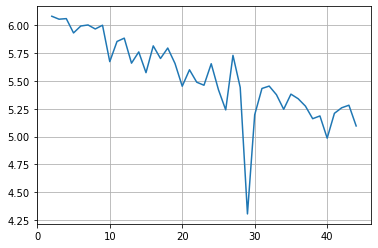

In [120]:
pyplot.plot(windows, entropies)
pyplot.grid()

In [132]:
window = 29

ciphers = []
for i in range(window):
    buf = bytearray()
    for j in range(i, len(input), window):
        buf.append(input[j])
    ciphers.append(buf)

In [135]:
key = bytearray()
for b in map(bestkey, ciphers):
    key.append(b)
key

bytearray(b'Terminator X: Bring the noise')

Alright, that makes way more sense. This Hamming distance approach is garbage compared to entropy calculations. I think a simple Fourier transform would have caught this too. The key is `Terminator X: Bring the noise`. Lets decrypt this message

In [140]:
print(repeating_key_xor(input, key).decode('utf-8'))

I'm back and I'm ringin' the bell 
A rockin' on the mike while the fly girls yell 
In ecstasy in the back of me 
Well that's my DJ Deshay cuttin' all them Z's 
Hittin' hard and the girlies goin' crazy 
Vanilla's on the mike, man I'm not lazy. 

I'm lettin' my drug kick in 
It controls my mouth and I begin 
To just let it flow, let my concepts go 
My posse's to the side yellin', Go Vanilla Go! 

Smooth 'cause that's the way I will be 
And if you don't give a damn, then 
Why you starin' at me 
So get off 'cause I control the stage 
There's no dissin' allowed 
I'm in my own phase 
The girlies sa y they love me and that is ok 
And I can dance better than any kid n' play 

Stage 2 -- Yea the one ya' wanna listen to 
It's off my head so let the beat play through 
So I can funk it up and make it sound good 
1-2-3 Yo -- Knock on some wood 
For good luck, I like my rhymes atrocious 
Supercalafragilisticexpialidocious 
I'm an effect and that you can bet 
I can take a fly girl and make her wet. 



🤦 More Vanilla Ice

### Challenge 7

Decrypt something in AES-128 ECB mode. The key is "YELLOW SUBMARINE".

In [7]:
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes


def decrypt_aes128_ecb(ciphertext, key):
    cipher = Cipher(algorithms.AES(key), modes.ECB())
    decryptor = cipher.decryptor()
    return decryptor.update(ciphertext) + decryptor.finalize()

In [10]:
import base64

key = b'YELLOW SUBMARINE'

with open("data/challenge7.txt") as f:
    input = base64.b64decode("".join(map(str.strip, f)))

print(decrypt_aes128_ecb(input, key).decode('utf-8'))

I'm back and I'm ringin' the bell 
A rockin' on the mike while the fly girls yell 
In ecstasy in the back of me 
Well that's my DJ Deshay cuttin' all them Z's 
Hittin' hard and the girlies goin' crazy 
Vanilla's on the mike, man I'm not lazy. 

I'm lettin' my drug kick in 
It controls my mouth and I begin 
To just let it flow, let my concepts go 
My posse's to the side yellin', Go Vanilla Go! 

Smooth 'cause that's the way I will be 
And if you don't give a damn, then 
Why you starin' at me 
So get off 'cause I control the stage 
There's no dissin' allowed 
I'm in my own phase 
The girlies sa y they love me and that is ok 
And I can dance better than any kid n' play 

Stage 2 -- Yea the one ya' wanna listen to 
It's off my head so let the beat play through 
So I can funk it up and make it sound good 
1-2-3 Yo -- Knock on some wood 
For good luck, I like my rhymes atrocious 
Supercalafragilisticexpialidocious 
I'm an effect and that you can bet 
I can take a fly girl and make her wet. 


🤦 Stahp

### Challenge 8 

Detect AES ECB mode.

The AES cipher is good... so lets just look for any repeated 16 byte blocks

In [26]:
def find_repeat(buffer, block_size=16):
    s = set()
    for i in range(0, len(buffer), block_size):
        h = hash(buffer[i:i+block_size])
        if h in s:
            return True
        s.add(h)
    return False


assert find_repeat(bytes.fromhex('aabbaabb'), 2)
assert not find_repeat(bytes.fromhex('abcddddd'), 2)

In [33]:
with open('data/challenge8.txt') as f:
    input = list(map(lambda x: bytes.fromhex(str.strip(x)), f))

In [36]:
winner = list(map(find_repeat, input)).index(True)

ciphertext = input[winner]
ciphertext

b'\xd8\x80a\x97@\xa8\xa1\x9bx@\xa8\xa3\x1c\x81\n=\x08d\x9a\xf7\r\xc0oO\xd5\xd2\xd6\x9ctL\xd2\x83\xe2\xdd\x05/kd\x1d\xbf\x9d\x11\xb04\x85B\xbbW\x08d\x9a\xf7\r\xc0oO\xd5\xd2\xd6\x9ctL\xd2\x83\x94u\xc9\xdf\xdb\xc1\xd4e\x97\x94\x9d\x9c~\x82\xbfZ\x08d\x9a\xf7\r\xc0oO\xd5\xd2\xd6\x9ctL\xd2\x83\x97\xa9>\xab\x8dj\xec\xd5fH\x91Tx\x9ak\x03\x08d\x9a\xf7\r\xc0oO\xd5\xd2\xd6\x9ctL\xd2\x83\xd4\x03\x18\x0c\x98\xc8\xf6\xdb\x1f*?\x9c@@\xde\xb0\xabQ\xb2\x993\xf2\xc1#\xc5\x83\x86\xb0o\xba\x18j'

In [43]:
key = b'YELLOW SUBMARINE'

decrypt_aes128_ecb(ciphertext, key)

b'M\x1d\x99\x1c\rW\xf5\xd4\xd9\x03:\xbfX\x15\xdd\xbd\xce\xb8\xd6\xf9\xc1\xc4\x1f\x1e\xbb\x951\x8d\xa9\xdf\x8b+\xc2*\xc7\xee\xd1\xc6\xc0\x7f\xa3(\x9b@F\x05\xa98\xce\xb8\xd6\xf9\xc1\xc4\x1f\x1e\xbb\x951\x8d\xa9\xdf\x8b+Ln\xc6Yk\xdbh~\x1d\xe5\xf0V\x84\xd7\xd3\x84\xce\xb8\xd6\xf9\xc1\xc4\x1f\x1e\xbb\x951\x8d\xa9\xdf\x8b+s\xe3\xd0\xf8\xa3\x19;\xa85\xb7.J\x03I\xa2^\xce\xb8\xd6\xf9\xc1\xc4\x1f\x1e\xbb\x951\x8d\xa9\xdf\x8b+\xe5%02]D\xac\xb8\xe2\xe0\xc48\x0f\xb6Rus\xa4<9\xb1\x81\xe2\xdcg\x8a\xa2%\x17\xafCd'

Oh well, not the right key, but definitely a repeated block so that has to be the one...